Ref: https://qiita.com/drk/items/a0dc582378c9f6ea0508
Dataset: https://datachemeng.com/pythonassignment/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, BatchNorm1d
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.loader import DataLoader

import mol2graph

# Device settings
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU!')
else:
    device = torch.device('cpu')
    print('The code uses CPU...')


The code uses CPU...


In [3]:
#学習
# Load dataset
mols = np.array([mol for mol in Chem.SDMolSupplier('./logSdataset1290_2d.sdf')])
proparties = np.array([mol.GetProp('logS') for mol in mols], dtype=float)

kf = KFold(n_splits=5, random_state=1640, shuffle=True) # n_split=5: データを5つに分割し、そのうちの一つをテストデータにする。(全部で5回クロスバリデーションが行われる)
train_idx, test_idx = list(kf.split(mols, np.zeros(len(mols))))[0]
train_X = [mol2graph.mol2vec(m) for m in mols[train_idx].tolist()]
train_y = proparties[train_idx]
for i,data in enumerate(train_X):
    data.y = torch.FloatTensor([train_y[i]]).to(device)

test_X = [mol2graph.mol2vec(m) for m in mols[test_idx].tolist()]
test_y = proparties[test_idx]
for i, data in enumerate(test_X):
    data.y = torch.FloatTensor([test_y[i]]).to(device)

train_loader = DataLoader(train_X, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=64, shuffle=True, drop_last=True)

# GCN
class MolecularGCN(torch.nn.Module):
    def __init__(self):
        super(MolecularGCN, self).__init__()
        self.n_features = 75
        self.n_conv_hidden = 3
        self.n_mlp_hidden = 3 # 多層パーセプトロン
        self.dim = 64
        self.graphconv1 = GCNConv(self.n_features, self.dim)
        self.bn1 = BatchNorm1d(self.dim)
        self.graphconv_hidden = ModuleList(
            [GCNConv(self.dim, self.dim, cached=False) for _ in range(self.n_conv_hidden)]
        )
        self.bn_conv = ModuleList(
            [BatchNorm1d(self.dim) for _ in range(self.n_conv_hidden)]
        )
        self.mlp_hidden =  ModuleList(
            [Linear(self.dim, self.dim) for _ in range(self.n_mlp_hidden)]
        )
        self.bn_mlp = ModuleList(
            [BatchNorm1d(self.dim) for _ in range(self.n_mlp_hidden)]
        )
        self.mlp_out = Linear(self.dim,1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.graphconv1(x, edge_index))
        x = self.bn1(x)
        for graphconv, bn_conv in zip(self.graphconv_hidden, self.bn_conv):
            x = graphconv(x, edge_index)
            x = bn_conv(x)
        x = global_add_pool(x, data.batch)
        for fc_mlp, bn_mlp in zip(self.mlp_hidden, self.bn_mlp):
            x = F.relu(fc_mlp(x))
            x = bn_mlp(x)
            x = F.dropout(x, p=0.1, training=self.training)
        x = self.mlp_out(x)
        return x 

# Training
model = MolecularGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y.unsqueeze(1))
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all/len(train_X)

def test(loader):
    model.eval()
    P, T, R2 = [], [], []
    for data in loader:
        data = data.to(device)
        y_pred = model(data)
        P.append(y_pred.detach().numpy())
        T.append(data.y.detach().numpy())
        R2.append(r2_score(y_pred.detach().numpy(), data.y.detach().numpy()))    
    return  np.concatenate(T), np.concatenate(P), np.mean(R2)

hist = {
    "mae":[],
    "r2":[],
    "test_r2":[],
    'y_true_train':[],
    'y_pred_train':[],
    'y_true_test':[],
    'y_pred_test':[],
}

for epoch in range(1, 200):
    train_mse = train(epoch)
    y_train, y_train_pred, train_r2 = test(train_loader)
    y_test, y_test_pred, test_r2 = test(test_loader)
    hist["mae"].append(train_mse)
    hist["r2"].append(train_r2)
    hist["test_r2"].append(test_r2)
    hist['y_true_train'].append(y_train)
    hist['y_pred_train'].append(y_train_pred)
    hist['y_true_test'].append(y_test)
    hist['y_pred_test'].append(y_test_pred)
    print(f'Epoch: {epoch}, Train MAE: {train_mse:.3}, Train_R2: {train_r2:.3}, Test_R2: {test_r2:.3}')

/home/higuchi/pytorch/GCN/mol2graph.py:282: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904035/work/torch/csrc/utils/tensor_new.cpp:245.)
  x=torch.tensor(node_f, dtype=torch.float), # shape [num_nodes, num_node_features] を持つ特徴行列


Epoch: 1, Train MAE: 9.65, Train_R2: -3.45e+02, Test_R2: -3.23e+02
Epoch: 2, Train MAE: 7.83, Train_R2: -22.9, Test_R2: -26.5
Epoch: 3, Train MAE: 6.98, Train_R2: -5.18, Test_R2: -5.77
Epoch: 4, Train MAE: 6.32, Train_R2: -1.4, Test_R2: -1.75
Epoch: 5, Train MAE: 5.87, Train_R2: -0.697, Test_R2: -0.837
Epoch: 6, Train MAE: 5.13, Train_R2: -0.504, Test_R2: -0.531
Epoch: 7, Train MAE: 4.48, Train_R2: -0.0634, Test_R2: -0.2
Epoch: 8, Train MAE: 3.85, Train_R2: 0.201, Test_R2: -0.000328
Epoch: 9, Train MAE: 3.06, Train_R2: 0.591, Test_R2: 0.471
Epoch: 10, Train MAE: 2.44, Train_R2: 0.364, Test_R2: 0.182
Epoch: 11, Train MAE: 1.83, Train_R2: 0.715, Test_R2: 0.613
Epoch: 12, Train MAE: 1.54, Train_R2: 0.627, Test_R2: 0.52
Epoch: 13, Train MAE: 1.2, Train_R2: 0.741, Test_R2: 0.605
Epoch: 14, Train MAE: 1.14, Train_R2: 0.904, Test_R2: 0.836
Epoch: 15, Train MAE: 0.948, Train_R2: 0.825, Test_R2: 0.753
Epoch: 16, Train MAE: 0.921, Train_R2: 0.874, Test_R2: 0.831
Epoch: 17, Train MAE: 0.967, Trai

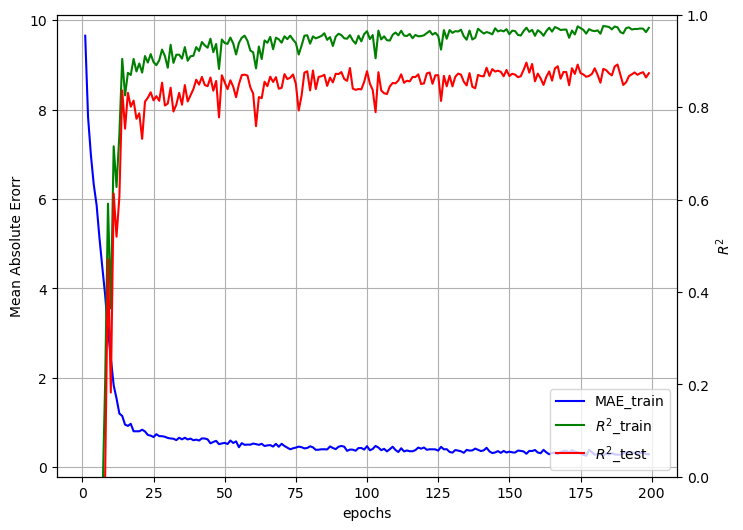

In [4]:
# 可視化
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
epochs = np.arange(1,200)
ax1.plot(epochs, hist['mae'], label="MAE_train", c='blue')
ax2.plot(epochs, hist['r2'], label=r"$R^2$_train", c='green')
ax2.plot(epochs, hist['test_r2'], label=r"$R^2$_test", c='red')
ax1.set_xlabel('epochs')
ax1.set_ylabel(r'Mean Absolute Erorr')
ax1.grid(True)
ax2.set_ylabel(r'$R^2$')
ax2.set_ylim([0,1])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')
plt.show()

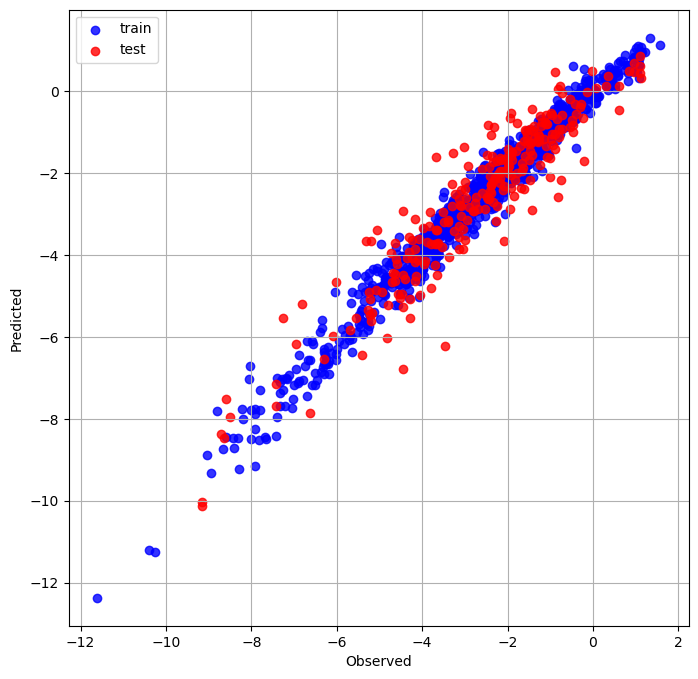

In [6]:
plt.figure(figsize=(8,8))
plt.grid(True)
plt.scatter(hist['y_true_train'][-1], hist['y_pred_train'][-1], color='blue', alpha=0.8, label='train')
plt.scatter(hist['y_true_test'][-1], hist['y_pred_test'][-1], color='red', alpha=0.8, label='test')
plt.ylabel("Predicted")
plt.xlabel("Observed")
plt.legend()

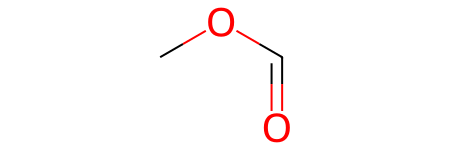

In [5]:
mols[30]